## Set Up Environment

In [1]:
# Import packages and set random.seed to 2 for consistent results
import numpy as np
import pandas as pd
import random
random.seed(2)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
mpl.rcParams['font.size'] = 9
import math

## Create Dataset

In [2]:
# Create a Netflix table/DataFrame that represents the population of Netflix users in the ad tier
# Include demographic data (gender, age, income %) and content viewing data (favorite genre, has kids profile [yes/no])
random.seed(2)

netflix_pop = 1000
user_id = list(range(1,netflix_pop+1))
user_email = [f"email{i}@domain.com" for i in range(1,netflix_pop+1)]

age = [random.randint(18, 70) for i in range(netflix_pop)]
gender = [random.choice(["Male", "Female"]) for i in range (netflix_pop)]
income_pct = [int(max(1, min(val, 100))) for val in [age_val * random.uniform(0.5, 1.5) + np.random.normal(0, 10) for age_val in age]] # Income % is positively correlated with age

genres = ["Thriller", "Comedy", "Romance", "Horror",
          "Drama", "Sci-Fi", "Talk Show", "Reality"]
favorite_genre = [random.choice(genres) for i in range (netflix_pop)]
has_kids_profile = [random.choice(["No","Yes"]) for i in range (netflix_pop)]

netflix_users_df = pd.DataFrame({
    "User ID":user_id,
    "User Email":user_email,
    "Age":age,
    "Gender":gender,
    "Income %":income_pct,
    "Favorite Genre":favorite_genre,
    "Has Kids Profile?":has_kids_profile})
netflix_user_ids = netflix_users_df['User ID'].tolist()

# Create 'Age Group' column and move it next to other demographic columns
bins = [18, 25, 35, 45, 55, 65, float('inf')]
labels = ['A18-24', 'A25-34', 'A35-44', 'A45-54', 'A55-64', 'A65+']
netflix_users_df['Age Group'] = pd.cut(netflix_users_df['Age'], bins=bins, labels=labels, right=False)
age_group_column = netflix_users_df.pop("Age Group")
netflix_users_df.insert(3, "Age Group", age_group_column)

bins = [1, 20, 40, 60, 80, float('inf')]
labels = ['0-20%', '21-40%', '41-60%', '61-80%', '81-100%']
netflix_users_df['Income % Group'] = pd.cut(netflix_users_df['Income %'], bins=bins, labels=labels, right=False)
age_group_column = netflix_users_df.pop('Income % Group')
netflix_users_df.insert(4, 'Income % Group', age_group_column)

# Retain all "Favorite Genre" category values so they are all visible in bar plots after being subsetted
netflix_users_df['Favorite Genre'] = pd.Categorical(netflix_users_df['Favorite Genre'], categories=genres)

# Assume that Netflix users don't have a kids profile if age <30 (younger users less likely to be parents)
netflix_users_df.loc[netflix_users_df['Age'] < 30, 'Has Kids Profile?'] = "No"

# Display first five rows of Netflix user table
netflix_users_df.head()

,User ID,User Email,Age,Age Group,Income % Group,Gender,Income %,Favorite Genre,Has Kids Profile?
0,1,email1@domain.com,21,A18-24,0-20%,Male,11,Romance,No
1,2,email2@domain.com,23,A18-24,21-40%,Female,24,Romance,No
2,3,email3@domain.com,23,A18-24,0-20%,Female,16,Thriller,No
3,4,email4@domain.com,41,A35-44,21-40%,Male,25,Romance,No
4,5,email5@domain.com,28,A25-34,41-60%,Male,47,Comedy,No


## DataExploration 

### Identify Source Audience 

In [3]:
top_spenders = ['email570@domain.com', 'email222@domain.com', 'email811@domain.com', 'email610@domain.com', 'email649@domain.com']        


### Identify Key Atttributes

In [4]:
# Define feature columns
numeric_columns = ['Age', 'Income %']
binary_columns = ['Gender_Female', 'Has Kids Profile?_Yes']
fave_genre_columns = ['Favorite Genre_Comedy',
                            'Favorite Genre_Romance', 'Favorite Genre_Horror',
                            'Favorite Genre_Drama', 'Favorite Genre_Sci-Fi',
                            'Favorite Genre_Talk Show', 'Favorite Genre_Reality',]

 ### Create Dummie varaibles for Categorical Variables

In [5]:
# Convert nominal data (gender, favorite genre, has kids profile?) into dummies. Keep N-1 dummies for N category values to prevent multicollinearity
dummies = pd.get_dummies(netflix_users_df[['Gender', 'Favorite Genre', 'Has Kids Profile?']])
dummies.drop(columns=['Gender_Male', 'Favorite Genre_Thriller', 'Has Kids Profile?_No'], inplace=True, axis=1)

# Concatenate the original netflix_user table with the dummies
netflix_users_df = pd.concat([netflix_users_df, dummies], axis=1)

#### Normalize Numerical Variables

In [6]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Normalize 'Age' and 'Income %' features in both tables before comparing them
netflix_users_df_normalized = netflix_users_df.copy()
netflix_users_df_normalized[numeric_columns] = scaler.fit_transform(netflix_users_df_normalized[numeric_columns])

# Identify Source Audience

In [7]:
# Identify the T-Moneybagz top spenders within Netflix's user table. Create a source audience containing the T-Moneybagz top spenders
source_audience_df = netflix_users_df[netflix_users_df['User Email'].isin(top_spenders)]
source_audience_ids = source_audience_df['User ID'].tolist()


# Look-a-like Model

### Calculate Distances

In [8]:
# Calculate pairwise distances using Euclidean distance for 'Age' and 'Income %' features and Cosine similarity for Gender, Favorite Genre, and Has Kids Profile? features
euclidean_distances_matrix = pairwise_distances(netflix_users_df[numeric_columns],
                                                source_audience_df[numeric_columns],
                                                metric='euclidean')

cosine_binary_columns_distances_matrix = pairwise_distances(netflix_users_df[binary_columns],
                                             source_audience_df[binary_columns],
                                             metric='cosine')

cosine_fave_genre_columns_distances_matrix = pairwise_distances(netflix_users_df[fave_genre_columns],
                                             source_audience_df[fave_genre_columns],
                                             metric='cosine')


# Combine the distances matrices with custom weightings based on domain expertise
combined_distances_matrix = (euclidean_distances_matrix * .8
                             + cosine_binary_columns_distances_matrix * .1
                             + cosine_fave_genre_columns_distances_matrix * .1)

In [9]:
### Calculate look a like score from weighted distances

In [10]:
# Create Lookalike Score columns in Netflix user table indicating how similar each Netflix user is to a source audience. Don't
lal_score = []
age_income_lal_score = []

for i, user_id in enumerate(netflix_user_ids):
    lal_score.append(min(combined_distances_matrix[i]))
netflix_users_df['Lookalike Score'] = lal_score

age_income_lal_score = []
for i, user_id in enumerate(netflix_user_ids):
    age_income_lal_score.append(min(euclidean_distances_matrix[i]))
netflix_users_df['Age Income Lookalike Score'] = age_income_lal_score

# Sort the Netflix table by user similarity. Lower values = greater similarity
netflix_users_df = netflix_users_df.sort_values(by='Lookalike Score')

# Identify Lookalike Audience

### Get List of total Target Population

In [11]:
# Create a copy of the Netflix user table with the source audience values removed
netflix_users_no_source_audience_df = netflix_users_df.tail(-len(source_audience_ids))

# For illustrative purposes, create an example lookalike audience that only looks for similarities in age and income
netflix_users_no_source_audience_df = netflix_users_no_source_audience_df.sort_values('Age Income Lookalike Score')
age_income_lal_df = netflix_users_no_source_audience_df.head(100)

### Visualize

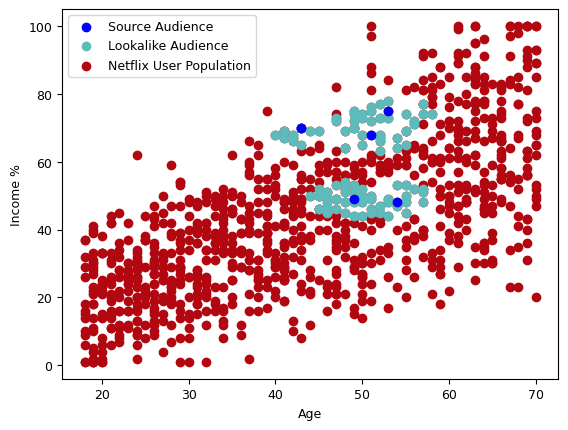

In [12]:
#plot user population
plt.scatter(netflix_users_df['Age'], netflix_users_df['Income %'], color = (178/255, 7/255, 16/255), label = 'Netflix User Population')
#plot lal population
plt.scatter(age_income_lal_df['Age'], age_income_lal_df['Income %'], color = (93/255, 187/255, 187/255), label = 'Lookalike Audience')
#plot source audience population
plt.scatter(source_audience_df['Age'], source_audience_df['Income %'], color = 'blue', label = 'Source Audience')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels))

# Label the axes
plt.xlabel('Age')
plt.ylabel('Income %')

# Show the plot
plt.show()